In [1]:
import os
import sys
import random
from langchain_community.vectorstores import Chroma
from langchain_experimental.utilities import PythonREPL
from IPython.display import display, Markdown

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

from complex_rag.src.document_retrieval import DocumentRetrieval
from enterprise_knowledge_retriever.src.advanced_rag_w_coding2 import CodeRAG
from enterprise_knowledge_retriever.prompts.examples import examples

CONFIG_PATH = os.path.join(kit_dir, "config.yaml")

/Users/codym/CAP/aisk_forked/ai-starter-kit/comp_rag_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
documentRetrieval = DocumentRetrieval()
*_, embedding_model_info, retrieval_info, _ = documentRetrieval.get_config_info()
embeddings = documentRetrieval.load_embedding_model()

In [3]:
vectorstore = Chroma(
    persist_directory=kit_dir + "/data/2_parts_adi.chromadb",
    embedding_function=embeddings,
)

2024-06-06 18:51:33,844 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [4]:
# instantiate rag
rag = CodeRAG(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)

# Initialize chains
rag.initialize()

# Build nodes
workflow = rag.create_rag_nodes()
print(workflow)

# Build graph
app = rag.build_rag_graph(workflow)

2024-06-06 18:51:35,748 [INFO] - Browser listening on: ws://127.0.0.1:50508/devtools/browser/9bab168b-ba6f-4437-8c14-f3e9a2b4f625
2024-06-06 18:51:38,891 [INFO] - terminate chrome process...



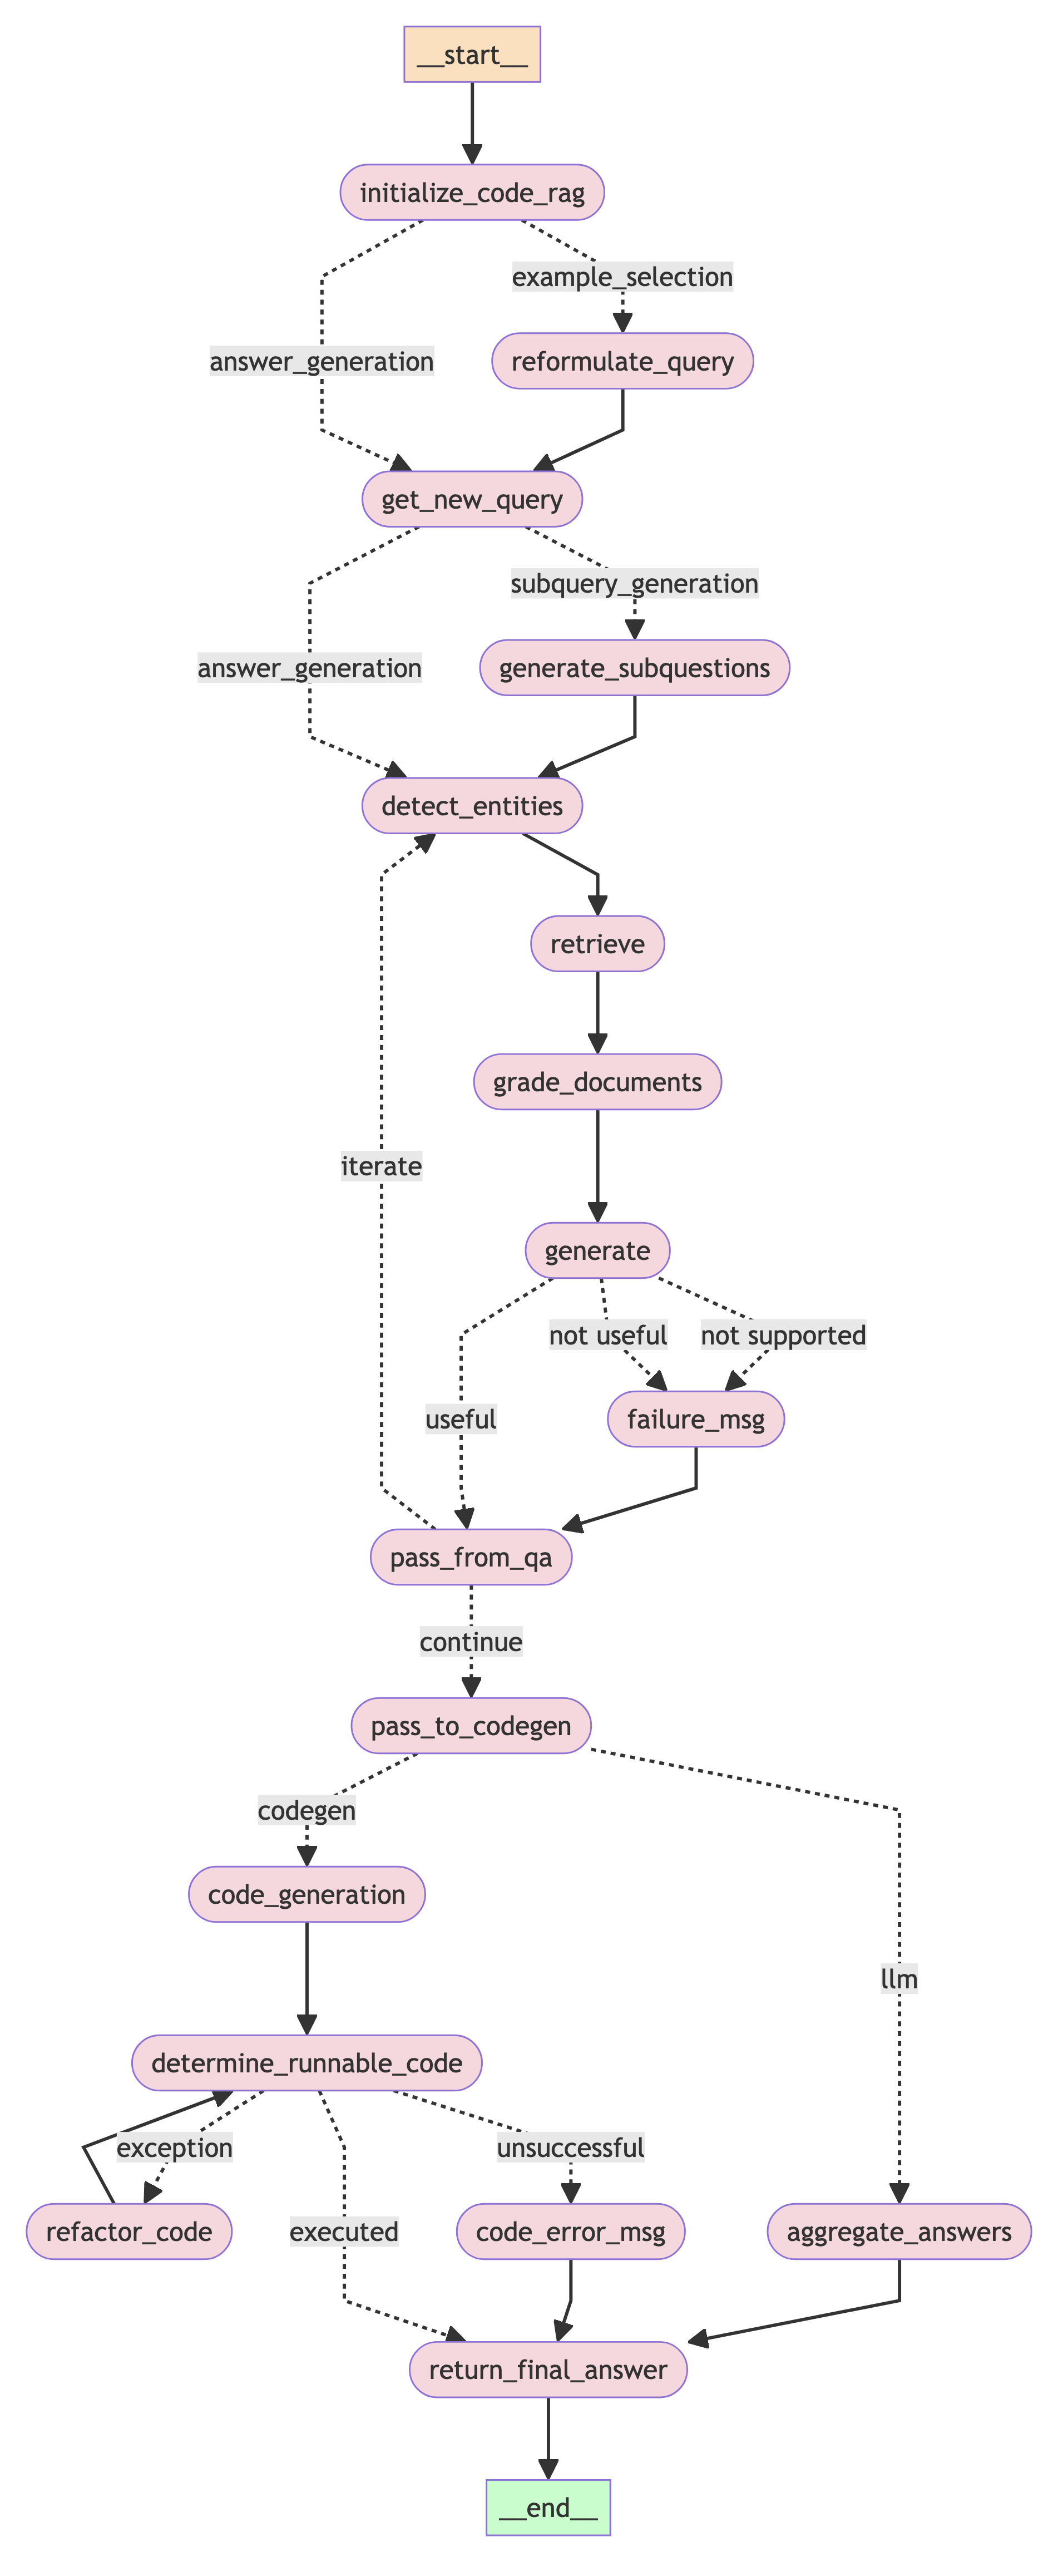

In [5]:
rag.display_graph(app)

In [6]:
response = rag.call_rag(
    app, "What has a higher input voltage, the max20810 or max20710?"
)

display(Markdown("---Response---"))
display(Markdown(response["answer"]))

---Initializing---
What has a higher input voltage, the max20810 or max20710?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
* What is the input voltage of the max20810?
* What is the input voltage of the max20710?
---DETERMINING ENTITIES---
question:  What has a higher input voltage, the max20810 or max20710?
entities:  ['max20810']
['max20810.pdf']
---ANSWERING SUBQUESTIONS---
* What is the input voltage of the max20810?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
3
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
* What is the input voltage of the max20810?
---DOCS---
length:  3665
Source: max20810, Text: 
Click here to ask an associate for production status of specific part numbers.

10A, 2MHz, 2.7V to 16V

2024-06-06 18:53:15,584 [WARNING] - Python REPL can execute arbitrary code. Use with caution.


Generated code: 
 # Extract the input voltage ranges from the intermediate answers
max20810_voltage_range = '2.7V to 16V'
max20710_voltage_range = '4.5V to 16V'

# Compare the voltage ranges
if float(max20810_voltage_range.split('to')[0].strip('V')) > float(max20710_voltage_range.split('to')[0].strip('V')):
    print("The MAX20810 has a higher input voltage.")
elif float(max20810_voltage_range.split('to')[0].strip('V')) < float(max20710_voltage_range.split('to')[0].strip('V')):
    print("The MAX20710 has a higher input voltage.")
else:
    print("Both ICs have the same maximum input voltage of 16V.")
---QCING CODE---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError("could not convert string to float: '2.7V '")
{'runnable': 'exception'}
Code status:  exception
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
exception
--ROUTING TO CODE REFACTOR---
--REFACTORING CODE---
---CODE TO REFACTOR---
# Extract the input voltage ranges from the intermediate answers
max20810_voltage_range = '2.7V to 16V'
max20710_voltage_range = '4.5V to 16V'

# Compare the voltage ranges
if float(max20810_voltage_range.split('to')[0].strip('V')) > float(max20710_voltage_range.split('to')[0].strip('V')):
    print("The MAX20810 has a higher input voltage.")
elif float(max20810_voltage_range.split('to')[0].strip('V')) < float(max20710_voltage_range.split('to')[0].strip('V')):
    print("The MAX20710 has a higher input voltage.")
else:
    print("Both ICs have the same maximum input voltage of 16V.")
updated codegen counter:  1
---CODE--- 
 # Extract the input voltage ranges from the intermediate answers
max20810_voltage_range = '2.7V to 16V'
max20710_voltage_ran

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Both ICs have the same maximum input voltage of 16V.

{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  1
executed
---EXECUTABLE---


---Response---

According to the provided generation, both the MAX20810 and MAX20710 have the same maximum input voltage of 16V.

So, the answer is:

The max20810 and max20710 have the same higher input voltage, which is 16V.

In [7]:
response = rag.call_rag(
    app, "What has a higher switching frequency, the max20810 or max20710?"
)

display(Markdown("---Response---"))
display(Markdown(response["answer"]))

---Initializing---
What has a higher switching frequency, the max20810 or max20710?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
* What is the switching frequency of the max20810?
* What is the switching frequency of the max20710?
---DETERMINING ENTITIES---
question:  What has a higher switching frequency, the max20810 or max20710?
entities:  ['max20810']
['max20810.pdf']
---ANSWERING SUBQUESTIONS---
* What is the switching frequency of the max20810?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
3
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
* What is the switching frequency of the max20810?
---DOCS---
length:  3623
Source: max20810, Text: 
Click here to ask an associate for production status of specific p

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---


---Response---

The MAX20810 has a higher switching frequency.

In [8]:
response = rag.call_rag(
    app, "What has a later revision date, the max20810 or max20710?"
)

display(Markdown("---Response---"))
display(Markdown(response["answer"]))

---Initializing---
What has a later revision date, the max20810 or max20710?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
* What is the revision date of the max20810?
* What is the revision date of the max20710?
---DETERMINING ENTITIES---
question:  What has a later revision date, the max20810 or max20710?
entities:  ['max20810']
['max20810.pdf']
---ANSWERING SUBQUESTIONS---
* What is the revision date of the max20810?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
3
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GENERATING---
---ANSWERING---
* What is the revision date of the max20810?
---DOCS---
length:  2437
Source: max20810, Text: 
l

e a d ( P b ) - f r e e / R o H S - c o m p

l i

a n t p a c k a g e .

M A X 2 0 8 1 0 A F E + 

---Response---

The MAX20810 has a later revision date.

In [9]:
response = rag.call_rag(
    app, "Can either the max20810 or max20710 support and input voltage of 3V?"
)

display(Markdown("---Response---"))
display(Markdown(response["answer"]))

---Initializing---
Can either the max20810 or max20710 support and input voltage of 3V?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
* Can the max20810 support an input voltage of 3V?
* Can the max20710 support an input voltage of 3V?
---DETERMINING ENTITIES---
question:  Can either the max20810 or max20710 support and input voltage of 3V?
entities:  ['max20810']
['max20810.pdf']
---ANSWERING SUBQUESTIONS---
* Can the max20810 support an input voltage of 3V?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
3
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GENERATING---
---ANSWERING---
* Can the max20810 support an input voltage of 3V?
---DOCS---
length:  3665
Source: max20810, Text: 
The device is available in 4.3mm x 6.55mm FC2QFN package. 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Execution timed out
{'runnable': 'exception'}
Code status:  exception
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
exception
--ROUTING TO CODE REFACTOR---
--REFACTORING CODE---
---CODE TO REFACTOR---
# Since we couldn't find the direct answer, let's try to find it indirectly!

import requests

# Step 1: Check the datasheet
url = "https://www.maximintegrated.com/en/products/datasheets.mvp"
params = {"part_number": "MAX20710"}
response = requests.get(url, params=params)

if response.status_code == 200:
    datasheet_html = response.text
    # Extract the relevant information from the datasheet HTML...
    max_input_voltage = None  # Initialize variable

    # ...and check if it supports an input voltage of 3V
    if max_input_voltage >= 3:  # Assuming we found the info in the datasheet
        print("Yes, the MAX20710 can support an input voltage of 3V.")
    else:
        print("No, the MAX20710 cannot support an input voltage of 3V.")

else:
    print("Failed to retrieve datashe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


---QCING CODE---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Execution timed out
{'runnable': 'exception'}
Code status:  exception
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  1
exception
--ROUTING TO CODE REFACTOR---
--REFACTORING CODE---
---CODE TO REFACTOR---
import requests

# Step 1: Check the datasheet
url = "https://www.maximintegrated.com/en/products/datasheets.mvp"
params = {"part_number": "MAX20710"}
response = requests.get(url, params=params)

if response.status_code == 200:
    datasheet_html = response.text
    # Extract the relevant information from the datasheet HTML...
    max_input_voltage = None  # Initialize variable

    # ...and check if it supports an input voltage of 3V
    if max_input_voltage is not None and max_input_voltage >= 3:  # Assuming we found the info in the datasheet
        print("Yes, the MAX20710 can support an input voltage of 3V.")
    else:
        print("No, the MAX20710 cannot support an input voltage of 3V.")
else:
    print("Failed to retrieve datasheet. Try another approach!")
updated codegen c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


---QCING CODE---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Execution timed out
{'runnable': 'exception'}
Code status:  exception
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  2
exception
--ROUTING TO CODE REFACTOR---
--REFACTORING CODE---
---CODE TO REFACTOR---
import requests

# Step 1: Check the datasheet
url = "https://www.maximintegrated.com/en/products/datasheets.mvp"
params = {"part_number": "MAX20710"}
response = requests.get(url, params=params)

if response.status_code == 200:
    datasheet_html = response.text
    # Extract the relevant information from the datasheet HTML...
    max_input_voltage = None   # Initialize variable

    # ...and check if it supports an input voltage of 3V
    if max_input_voltage is not None and max_input_voltage >= 3:   # Assuming we found the info in the datasheet
        print("Yes, the MAX20710 can support an input voltage of 3V.")
    else:
        print("No, the MAX20710 cannot support an input voltage of 3V.")
else:
    print(f"Failed to retrieve datasheet. Status code: {response.status_code}. T

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


---QCING CODE---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Execution timed out
{'runnable': 'exception'}
Code status:  exception
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  3
exception


---Response---

I apologize, but I cannot provide the final answer due to a lack of grounding in documents or an ability to generate and run code that is required to solve the task. The generation provided indicates that the execution timed out, which means that there is not enough information available to answer the question accurately.

In [10]:
response = rag.call_rag(
    app, "What are the differences between the max20710 and max20810?"
)

display(Markdown("---Response---"))
display(Markdown(response["answer"]))

---Initializing---
What are the differences between the max20710 and max20810?


2024-06-06 19:02:30,749 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


---Decision---
{'generate_or_example': 'example_selection'}
---ROUTE TO EXAMPLE SELECTION---
---REFORMULATING QUESTION---
examples from state:  [{'query': 'What are the features of the max2000 and max1000?', 'example': 'What are the benefits and features of the max2000 and max1000?'}, {'query': 'What are the differences between the max2000 and max1000?', 'example': 'What are the input voltage, output voltage, and switching frequency of the max2000 and max1000?'}]
selected examples [{'example': 'What are the input voltage, output voltage, and switching frequency of the max2000 and max1000?', 'query': 'What are the differences between the max2000 and max1000?'}]
---FOUND EXAMPLES---
['What are the differences between the max2000 and max1000?\nWhat are the input voltage, output voltage, and switching frequency of the max2000 and max1000?']
---REFORMULATED QUESTION---
What are the input voltage, output voltage, and switching frequency of the max20710 and max20810?
---ROUTING QUESTION---
su

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---


---Response---

The main differences between the max20710 and max20810 are:

1. Output voltage range: The output voltage range is different for each device, but unfortunately, I couldn't find any information on the output voltage of the max20710.
2. Switching frequency range: The max20710 has a switching frequency range that can be set to 400kHz, 600kHz, or 800kHz through C_SELB and can be overridden through PMBus to 400kHz, 500kHz, 600kHz, 700kHz, 800kHz, or 900kHz. In contrast, the max20810 has a switching frequency range that can be configured from 500kHz to 2MHz, providing more flexibility in terms of design optimization.